In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import dendrotweaks as dd
dd.__version__

--No graphics will be displayed.


'0.5.1'

In [3]:
os.makedirs('examples', exist_ok=True)
if not os.listdir('examples/'):
    print("Downloading example data...")
    dd.download_example_data('examples')

In [4]:
from dendrotweaks.biophys.io import MODFileConverter

Park 2019 Channels

In [8]:
park_mod_dir = os.path.join("examples", "Park_2019", "biophys", "mod")
template = os.path.join("examples", "Templates", "jaxley.py")

out_dir = os.path.join("examples", "Park_2019", "biophys", "python")
os.makedirs(out_dir, exist_ok=True)

converter = MODFileConverter()

converted, failed = [], []

for mod_path in sorted(glob.glob(os.path.join(park_mod_dir, "*.mod"))):
    txt = open(mod_path, "r", encoding="utf-8", errors="ignore").read()

    base = os.path.splitext(os.path.basename(mod_path))[0]  # "Na"
    out_py = os.path.join(out_dir, f"{base}jx.py")  # "Najx.py"

    try:
        converter.convert(mod_path, out_py, template)
        converted.append((mod_path, out_py))
    except Exception as e:
        failed.append((mod_path, repr(e)))

print(f"Converted: {len(converted)} | Failed: {len(failed)}")
if failed:
    print("First few failures:")
    for p, err in failed[:5]:
        print("  ", p, "->", err)

Saved content to examples/Park_2019/biophys/python/CaHVAjx.py
Saved content to examples/Park_2019/biophys/python/CaLVAjx.py
Saved content to examples/Park_2019/biophys/python/KCajx.py
Saved content to examples/Park_2019/biophys/python/Kajx.py
Saved content to examples/Park_2019/biophys/python/Kmjx.py
Saved content to examples/Park_2019/biophys/python/Kvjx.py
Saved content to examples/Park_2019/biophys/python/Najx.py
Converted: 7 | Failed: 0


In [5]:
import jaxley as jx

In [6]:
from examples.Park_2019.biophys.python.Najx import Na
from examples.Park_2019.biophys.python.Kvjx import Kv
from examples.Park_2019.biophys.python.Kmjx import Km
from examples.Park_2019.biophys.python.KCajx import KCa
from examples.Park_2019.biophys.python.Kajx import Ka
from examples.Park_2019.biophys.python.CaLVAjx import CaLVA
from examples.Park_2019.biophys.python.CaHVAjx import CaHVA
from jaxley.channels import Leak

PARK 2019 Morphology

In [22]:
cell = jx.read_swc("examples/Park_2019/morphology/main.swc", ncomp=1)
print(cell.group_names)  

['apical', 'axon', 'basal', 'soma']


In [24]:
print(cell.shape)
cell.show()

(53, 53)


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,0,1,1,1,0,0
2,0,2,2,2,0,0
3,0,3,3,3,0,0
4,0,4,4,4,0,0
5,0,5,5,5,0,0
6,0,6,6,6,0,0
7,0,7,7,7,0,0
8,0,8,8,8,0,0
9,0,9,9,9,0,0


(-196.068821134, 183.52763616100006, -148.92450461250002, 230.67195268250003)

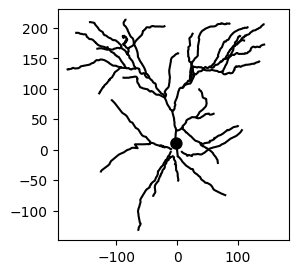

In [23]:
cell.vis()
plt.axis("square")

In [26]:
cell = jx.read_swc("examples/Park_2019/morphology/main.swc", ncomp=1)

# sanity: how many comps in each domain?
print(cell.nodes[["soma","basal","apical"]].sum())

soma       2
basal      7
apical    43
dtype: int64


5 MultiCompartment Model 

In [7]:
soma_branch  = jx.Branch([jx.Compartment()]) # 1 comp
basal_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps
apic_branch = jx.Branch([jx.Compartment(), jx.Compartment()]) # 2 comps

cell = jx.Cell([soma_branch, basal_branch, apic_branch], parents=[-1, 0, 0])


In [8]:
print(cell.nodes.columns)

Index(['local_cell_index', 'local_branch_index', 'local_comp_index', 'length',
       'radius', 'axial_resistivity', 'capacitance', 'v', 'area', 'volume',
       'resistive_load_in', 'resistive_load_out', 'x', 'y', 'z',
       'global_cell_index', 'global_branch_index', 'global_comp_index',
       'controlled_by_param'],
      dtype='object')


In [9]:
v_init = -79.0
Rm = 11000.0
Ri = 100.0
Cm = 1.0

cell.set("v", v_init)
cell.set("axial_resistivity", Ri) 
cell.branch(0).set("capacitance", Cm)  # soma: 1
cell.branch(1).set("capacitance", 2 * Cm) # dend: 2
cell.branch(2).set("capacitance", 2 * Cm) # dend: 2


In [ ]:
cell.branch(0).comp(0).set("length", 20.0);  cell.branch(0).comp(0).set("radius", 10.0)  # soma
for b in [1, 2]:
    cell.branch(b).comp(0).set("length", 150.0); cell.branch(b).comp(0).set("radius", 1.0)  # prox dend
    cell.branch(b).comp(1).set("length", 150.0); cell.branch(b).comp(1).set("radius", 0.7)  # distal dend

In [10]:
cell.insert(Leak())
cell.set("Leak_gLeak", 1.0 / Rm)
cell.set("Leak_eLeak", v_init) 

In [ ]:
na = Na()
na.channel_params["E_na"] = 60.0

kv = Kv()
kv.channel_params["E_k"] = -80.0

cahva = CaHVA()
cahva.channel_params["E_ca"] = 140.0

calva = CaLVA()
calva.channel_params["E_ca"] = 140.0

cell.insert(na)
cell.insert(kv)
cell.insert(cahva)
cell.insert(calva)

In [11]:
cell.insert(Na())
cell.insert(Kv())
cell.insert(Km())
cell.insert(Ka())
cell.insert(KCa())
cell.insert(CaHVA())
cell.insert(CaLVA())

(base.py, line 2680)
(base.py, line 2684)
(base.py, line 2684)
(base.py, line 2660)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2684)
(base.py, line 2684)


In [12]:
def cols_for_chan(chan):
    suffix = f"_{chan}".lower()
    return [c for c in cell.nodes.columns if c.lower().endswith(suffix)]

for ch in ["Na", "Kv", "Km", "Ka", "KCa", "CaHVA", "CaLVA"]:
    print(ch, cols_for_chan(ch))

Na ['gbar_Na', 'Rma_Na', 'Rmb_Na', 'v12m_Na', 'qm_Na', 'Rhb_Na', 'Rha_Na', 'v12ha_Na', 'v12hb_Na', 'qh_Na', 'v12hinf_Na', 'qhinf_Na', 'temp_Na', 'q10_Na', 'm_Na', 'h_Na']
Kv ['gbar_Kv', 'Ra_Kv', 'Rb_Kv', 'v12_Kv', 'q_Kv', 'temp_Kv', 'q10_Kv', 'n_Kv']
Km ['gbar_Km', 'Ra_Km', 'Rb_Km', 'v12_Km', 'q_Km', 'temp_Km', 'q10_Km', 'n_Km']
Ka ['gbar_Ka', 'vhalfn_Ka', 'vhalfl_Ka', 'a0l_Ka', 'a0n_Ka', 'zetan_Ka', 'zetal_Ka', 'gmn_Ka', 'gml_Ka', 'lmin_Ka', 'nmin_Ka', 'pw_Ka', 'tq_Ka', 'qq_Ka', 'q10_Ka', 'qtl_Ka', 'temp_Ka', 'n_Ka', 'l_Ka']
KCa ['gbar_KCa', 'caix_KCa', 'Ra_KCa', 'Rb_KCa', 'temp_KCa', 'q10_KCa', 'n_KCa']
CaHVA ['gbar_CaHVA', 'Rma_CaHVA', 'Rmb_CaHVA', 'v12ma_CaHVA', 'v12mb_CaHVA', 'qma_CaHVA', 'qmb_CaHVA', 'Rha_CaHVA', 'Rhb_CaHVA', 'v12ha_CaHVA', 'v12hb_CaHVA', 'qha_CaHVA', 'qhb_CaHVA', 'temp_CaHVA', 'q10_CaHVA', 'm_CaHVA', 'h_CaHVA']
CaLVA ['gbar_CaLVA', 'v12m_CaLVA', 'v12h_CaLVA', 'vwm_CaLVA', 'vwh_CaLVA', 'am_CaLVA', 'ah_CaLVA', 'vm1_CaLVA', 'vm2_CaLVA', 'vh1_CaLVA', 'vh2_CaLVA', 'w

In [13]:
soma = cell.branch(0)
dend = [cell.branch(1), cell.branch(2)]

soma.set("gbar_Na", 504.9)
soma.set("gbar_Kv", 50.0)
soma.set("gbar_Km", 2.794)
soma.set("gbar_Ka", 0.0054)
soma.set("gbar_KCa", 2.1)
soma.set("gbar_CaHVA", 0.05)
soma.set("gbar_CaLVA", 3e-5)

for br in dend:
    br.set("gbar_Na", 302.94)
    br.set("gbar_Kv", 1.5)
    br.set("gbar_Km", 1.27)
    br.set("gbar_Ka", 0.108)
    br.set("gbar_KCa", 2.1)
    br.set("gbar_CaHVA", 0.05)
    br.set("gbar_CaLVA", 3e-5)

In [36]:
print([c for c in cell.nodes.columns if c.lower() in ("ena","ek","eca","cai") or "ena" in c.lower() or "cai" in c.lower()])

['caix_KCa']


In [38]:
[c for c in cell.nodes.columns if c.lower().startswith("e_")]
print(CaHVA().current_name, CaLVA().current_name)

i_ca i_ca


In [39]:
for k in ["E_na", "E_k", "E_ca"]:
    print(k, k in cell.nodes.columns)

E_na False
E_k False
E_ca False


In [40]:
print(Na().channel_params.get("E_na"))
print(Kv().channel_params.get("E_k"))
print(CaHVA().channel_params.get("E_ca"))

None
None
None


In [41]:
print(Na().channel_params)
print(Kv().channel_params)
print(CaHVA().channel_params)

{'gbar_Na': 0.0, 'Rma_Na': 0.182, 'Rmb_Na': 0.14, 'v12m_Na': -30, 'qm_Na': 9.8, 'Rhb_Na': 0.0091, 'Rha_Na': 0.024, 'v12ha_Na': -45, 'v12hb_Na': -70, 'qh_Na': 5, 'v12hinf_Na': -60, 'qhinf_Na': 6.2, 'temp_Na': 23, 'q10_Na': 2.3}
{'gbar_Kv': 0.0, 'Ra_Kv': 0.02, 'Rb_Kv': 0.006, 'v12_Kv': 25, 'q_Kv': 9, 'temp_Kv': 23, 'q10_Kv': 2.3}
{'gbar_CaHVA': 0.0, 'Rma_CaHVA': 0.5, 'Rmb_CaHVA': 0.1, 'v12ma_CaHVA': -27, 'v12mb_CaHVA': -75, 'qma_CaHVA': 3.8, 'qmb_CaHVA': 17, 'Rha_CaHVA': 0.000457, 'Rhb_CaHVA': 0.0065, 'v12ha_CaHVA': -13, 'v12hb_CaHVA': -15, 'qha_CaHVA': 50, 'qhb_CaHVA': 28, 'temp_CaHVA': 23, 'q10_CaHVA': 2.3}


In [42]:
print(cell.branch(0).nodes[["gbar_Na","gbar_Kv","gbar_Ka"]])
print(cell.branch(1).nodes[["gbar_Na","gbar_Kv","gbar_Ka"]])

   gbar_Na  gbar_Kv  gbar_Ka
0    504.9     50.0   0.0054
   gbar_Na  gbar_Kv  gbar_Ka
1   302.94      1.5    0.108
2   302.94      1.5    0.108


In [14]:
print("CaHVA current_name:", CaHVA().current_name)
print("CaLVA current_name:", CaLVA().current_name)

CaHVA current_name: i_ca
CaLVA current_name: i_ca


In [15]:
from jaxley.pumps import CaPump
cell.insert(CaPump())

(base.py, line 2666)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2680)
(base.py, line 2684)
(base.py, line 2684)


In [16]:
from pathlib import Path

p = Path("examples/Park_2019/biophys/python/KCajx.py")
s = p.read_text()
p.write_text(s.replace("caix_KCa", "CaCon_i"))
print("Patched KCajx.py: caix_KCa -> CaCon_i")

Patched KCajx.py: caix_KCa -> CaCon_i


In [17]:
na = Na()
print(hasattr(na, "set_tadj"))
print([m for m in dir(na) if "tadj" in m.lower()])

True
['set_tadj', 'tadj']


In [18]:
temperature = 37.0

channels = [Na(), Kv(), Km(), Ka(), KCa(), CaHVA(), CaLVA()]

for ch in channels:
    ch.set_tadj(temperature)   # only works if method exists

cell.insert(Leak())
for ch in channels:
    cell.insert(ch)

In [21]:
import jaxley
import jaxley.synapses as syn

print("jaxley version:", getattr(jaxley, "__version__", "unknown"))
print([name for name in dir(syn) if "Synapse" in name])

jaxley version: 0.12.0
['IonotropicSynapse', 'Synapse', 'TanhConductanceSynapse', 'TanhRateSynapse', 'TestSynapse']


In [23]:
import numpy as np
import jaxley as jx
from jaxley.connect import connect
from jaxley.synapses import IonotropicSynapse

# ---- postsyn cell (already built earlier) ----
post_cell = cell   # <-- THIS is the missing definition

def poisson_train(rate_hz, T, dt, on, off, rng):
    """Binary (0/1) spikes in [on:off) with Poisson rate."""
    p = rate_hz * (dt / 1000.0)  # dt(ms)->s
    x = np.zeros(T, dtype=float)
    x[on:off] = (rng.random(off-on) < p)
    return x

def make_presyn_voltage(spike_train_01, v_rest=-70.0, v_spike=20.0, spike_width_steps=1):
    """Turn 0/1 spikes into a voltage trace with brief depolarizing pulses."""
    v = np.full_like(spike_train_01, v_rest, dtype=float)
    idx = np.where(spike_train_01 > 0.5)[0]
    for t in idx:
        v[t:t+spike_width_steps] = v_spike
    return v

# ---- 5 synapse targets on the 5-comp postsyn cell ----
targets = [
    ("syn0_soma",  0, 0),
    ("syn1_bP",    1, 0),
    ("syn2_bD",    1, 1),
    ("syn3_aP",    2, 0),
    ("syn4_aD",    2, 1),
]
Nsyn = len(targets)

# ---- build network: 5 dummy presyn + 1 postsyn ----
pre_cells = [jx.Cell() for _ in range(Nsyn)]
net = jx.Network(pre_cells + [post_cell])
post_idx = Nsyn

# connect each presyn cell to a specific post compartment
for i, (_, b, c) in enumerate(targets):
    connect(net.cell(i), net.cell(post_idx).branch(b).comp(c), IonotropicSynapse())

print("edge columns:", list(net.edges.columns))

# ---- set synapse strengths per edge ----
if "IonotropicSynapse_gS" in net.edges.columns:
    net.edges["IonotropicSynapse_gS"] = np.array([0.005]*Nsyn, dtype=float)
else:
    raise KeyError("Couldn't find IonotropicSynapse_gS in net.edges.columns")

# reversal potential: depends on your version; set if present
if "IonotropicSynapse_e_syn" in net.edges.columns:
    net.edges["IonotropicSynapse_e_syn"] = 0.0   # excitatory

# ---- drive with binary patterns -> Poisson spikes -> presyn voltage clamp ----
dt = 0.025   # ms
t_max = 200.0
T = int(t_max / dt)

stim_on  = 50.0
stim_off = 150.0
on = int(stim_on / dt)
off = int(stim_off / dt)

pattern = np.array([1, 0, 1, 0, 1], dtype=int)
rate_on_hz = 30.0
rng = np.random.default_rng(0)

# choose spike width; 1 step is 0.025 ms; usually better to use ~0.5–1 ms
spike_width_steps = max(1, int(0.5 / dt))  # 0.5 ms pulses

for i in range(Nsyn):
    spikes01 = poisson_train(rate_on_hz if pattern[i] else 0.0, T, dt, on, off, rng)
    vpre = make_presyn_voltage(spikes01, v_rest=-70.0, v_spike=20.0, spike_width_steps=spike_width_steps)

    net.cell(i).set("v", -70.0)
    net.cell(i).clamp("v", vpre)

# ---- record: soma + local dend voltages ----
net.cell(post_idx).branch(0).comp(0).record("v")
for _, b, c in targets[1:]:
    net.cell(post_idx).branch(b).comp(c).record("v")

traces = jx.integrate(net, delta_t=dt)

edge columns: ['global_edge_index', 'index_within_type', 'pre_index', 'post_index', 'type', 'type_ind', 'pre_locs', 'post_locs', 'IonotropicSynapse_gS', 'IonotropicSynapse_e_syn', 'IonotropicSynapse_k_minus', 'IonotropicSynapse_v_th', 'IonotropicSynapse_delta', 'IonotropicSynapse_s', 'controlled_by_param']
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


AttributeError: 'Ka' object has no attribute 'temperature'